### Motivating The Autoencoder architecture 

Feed Forwards Network learn progressively after each layer and learn a more relevant (important) representation of the input,in brief Autoencoders are a neural network architecture that compresses the input and decompress it,thus learning an efficient representation of the input called "coding" this codings contribute to create a new set of features that is more efficient than the input ,this was the principal task motivating this architecture in the Infamous paper [Reducing the Dimensionality of Data with Neural Networks by *G. E. Hinton  and R. R. Salakhutdinov *](https://www.cs.toronto.edu/~hinton/science.pdf)  .

The architecture of the nerual networks is made of two components and *encoder* and *decoder*

The Encoder is responsible of producing a low-dimensional coding of the input & the decoder is responsible for mapping this coding to reconstruct the output .

![autoencoder](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

### Some Notes about Autoencoders

* Data-specific: Autoencoders are only able to meaningfully compress data similar to what they have been trained on. Since they learn features specific for the given training data, they are different than a standard data compression algorithm like gzip. So we can’t expect an autoencoder trained on handwritten digits to compress landscape photos.

* Lossy: The output of the autoencoder will not be exactly the same as the input, it will be a close but degraded representation. This degraded representation contains the most important *codings* only ,thus they are similar to PCA (which we will explore later)

* Unsupervised algorithm : Autoencoders can be used to "pretrain" your neural network in other words you get better initialize weights this helps reducing training time .[Layer wise pre training with autoencoders](http://www.cbs.dtu.dk/courses/DeepLearning_workshop/VanessaJurtz.pdf) , they also don't need labeled data just throw an input and see how the output reconstruction evolves with time .

Let's review some terms before we start :

* The encoding,decoding layers can be as deep as we like 
* The representation of the network ressembles a sandwich in the case of **stacked autoencoders** 
![sda](https://cdn-images-1.medium.com/max/800/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)
* Loss function: we either use mean squared error (mse) or binary crossentropy. If the input values are in the range [0, 1] then we typically use crossentropy, otherwise we use the mean squared error. For more details check out this [video](https://www.youtube.com/watch?v=xTU79Zs4XKY)

 ### Let's build an autoencoder

In [6]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam

Using TensorFlow backend.


In [7]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [8]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    n = 5
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [10]:
input_size = 784
hidden_size = 128
code_size = 32
#setting the architecture
input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)
#building and compiling the model
autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=3)

Epoch 1/3
60000/60000 [==============================] - 13s - loss: 0.1345    
Epoch 2/3
60000/60000 [==============================] - 12s - loss: 0.0979    
Epoch 3/3
60000/60000 [==============================] - 14s - loss: 0.0925    


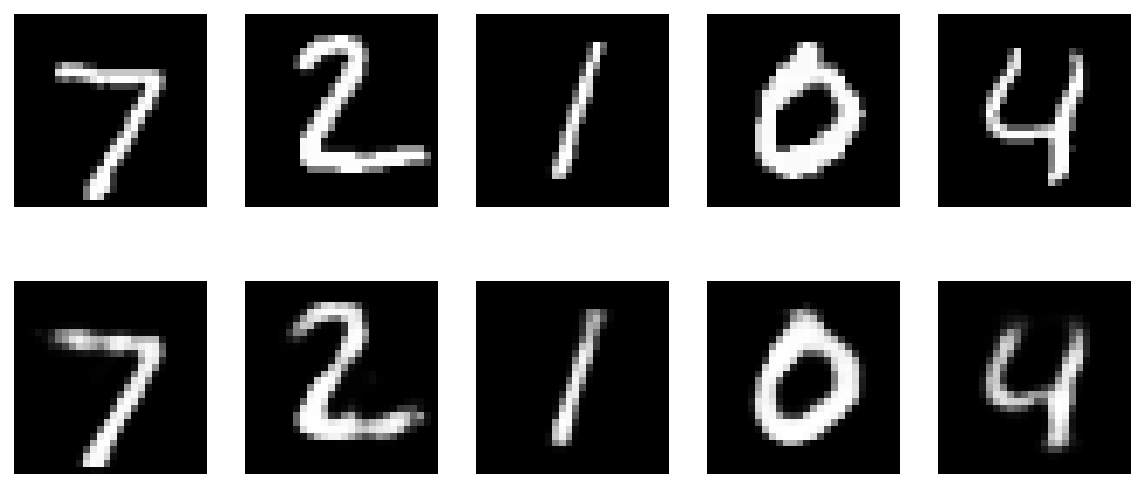

In [11]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))


The original digits are in the upper row and reconstructed outputs on the lower row , you can see that the picture don't differ much, and by constraining the code_size to 32 what we do is actually reproduce PCA ,playing with code_size will output different outputs (Explore that :) 

### Denoising Autoencoders
To force the autoencoder to learn a more efficient mapping we can add noise to the input and force it to "clean it" or "denoise" the output .This way the autoencoders is forced to not **copy** the data but actually process it ,let's add a gaussian noise to our images and see how the network performs


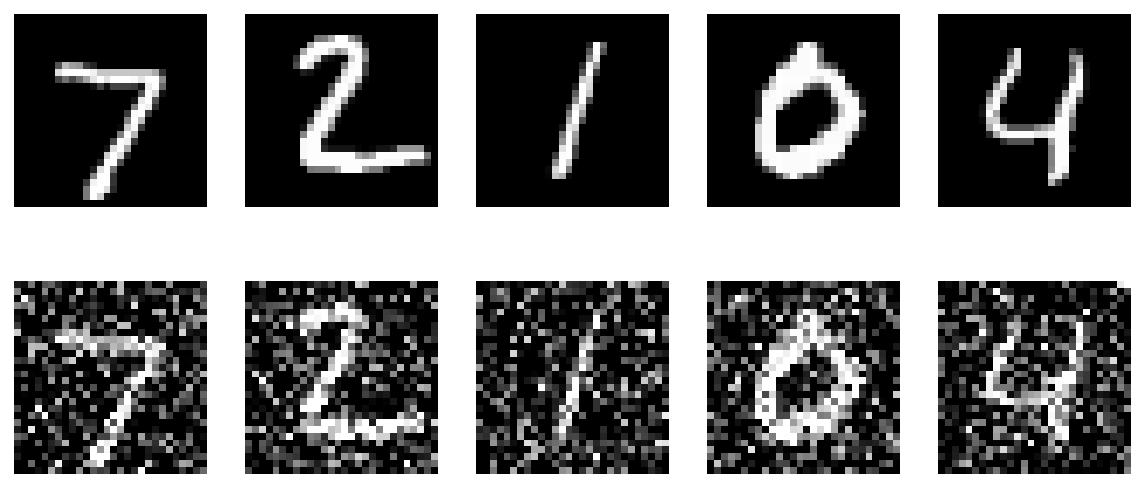

In [7]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

n = 5
plt.figure(figsize=(10, 4.5))
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')

In [8]:
nput_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 17s - loss: 0.1642    
Epoch 2/10
60000/60000 [==============================] - 17s - loss: 0.1279    
Epoch 3/10
60000/60000 [==============================] - 18s - loss: 0.1217    
Epoch 4/10
60000/60000 [==============================] - 16s - loss: 0.1188    
Epoch 5/10
60000/60000 [==============================] - 20s - loss: 0.1168    
Epoch 6/10
60000/60000 [==============================] - 17s - loss: 0.1153    
Epoch 7/10
60000/60000 [==============================] - 17s - loss: 0.1141    
Epoch 8/10
60000/60000 [==============================] - 15s - loss: 0.1130    
Epoch 9/10
60000/60000 [==============================] - 15s - loss: 0.1119    
Epoch 10/10
60000/60000 [==============================] - 15s - loss: 0.1109    


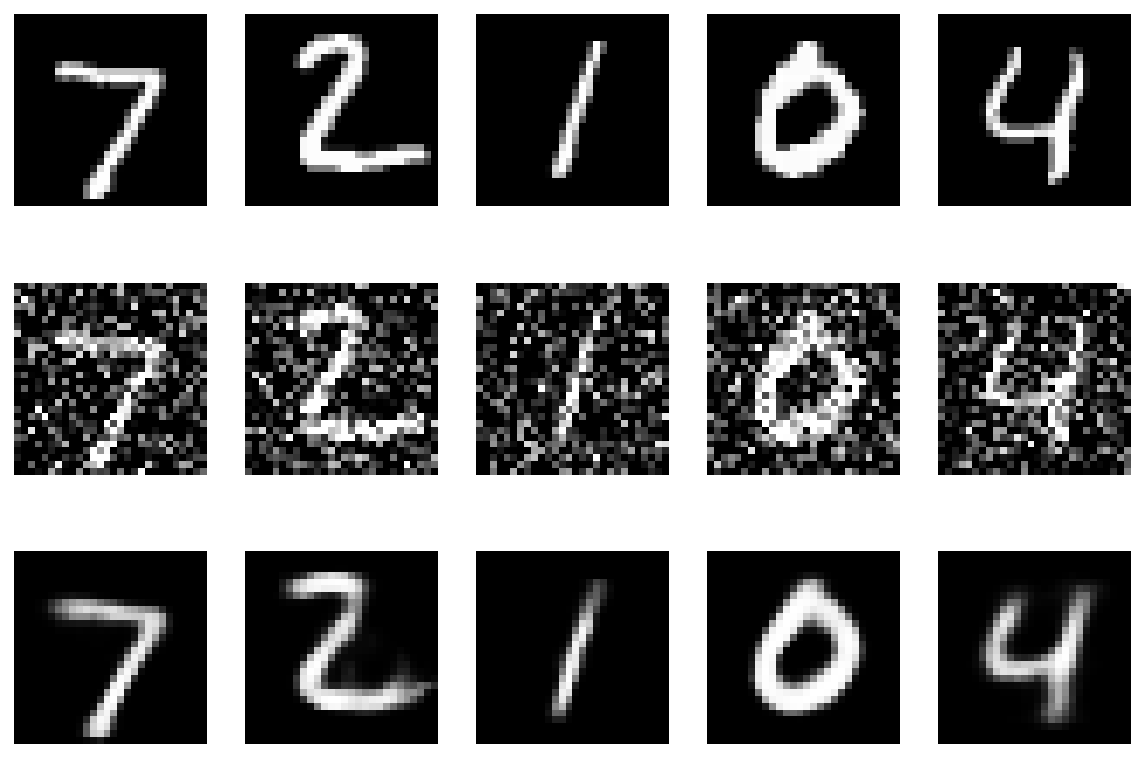

In [9]:

n = 5
plt.figure(figsize=(10, 7))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')

The first row is input 
The second row is the noisy input
The third row is the denoised input 
We can see how the autoencoder progressively learned to denoise the input and learn a proper coding

In [13]:
# building the architecture from G.Hinton and Salakhutdinov
input_size = 784
code_size = 32
#setting the architecture
input_img = Input(shape=(input_size,))
hidden_1 = Dense(1000, activation='relu')(input_img)
hidden_2 = Dense(500,activation='relu')(hidden_1)
hidden_3 = Dense(250,activation='relu')(hidden_2)
code = Dense(32, activation='relu')(hidden_3)
hidden_4 = Dense(250, activation='relu')(code)
hidden_5 = Dense(500,activation='relu')(hidden_4)
hidden_6 = Dense(1000,activation='relu')(hidden_5)
output_img = Dense(input_size, activation='sigmoid')(hidden_6)
#building and compiling the model
autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
encoder_history = autoencoder.fit(x_train, x_train, epochs=2)

Epoch 1/2
60000/60000 [==============================] - 126s - loss: 0.1422   
Epoch 2/2
60000/60000 [==============================] - 124s - loss: 0.1074   


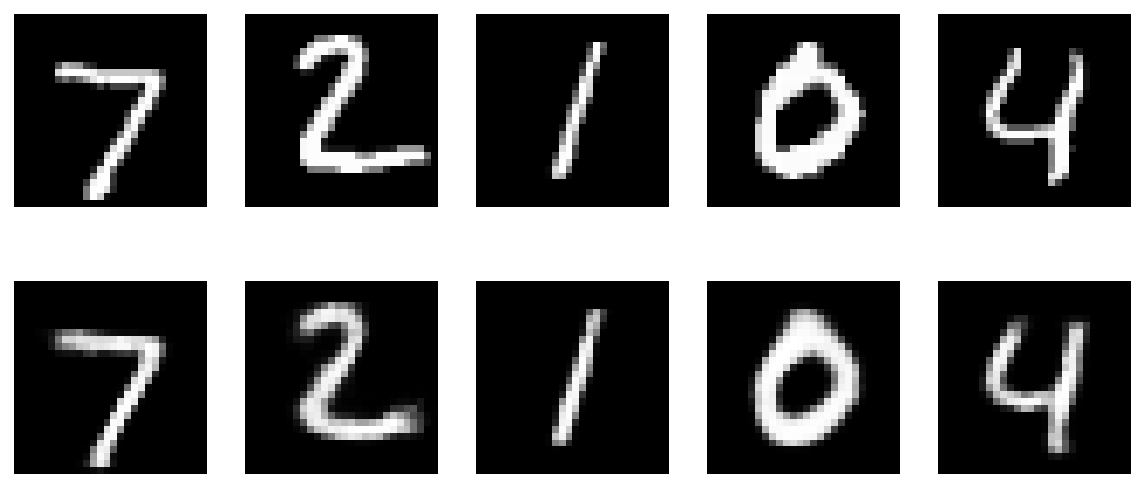

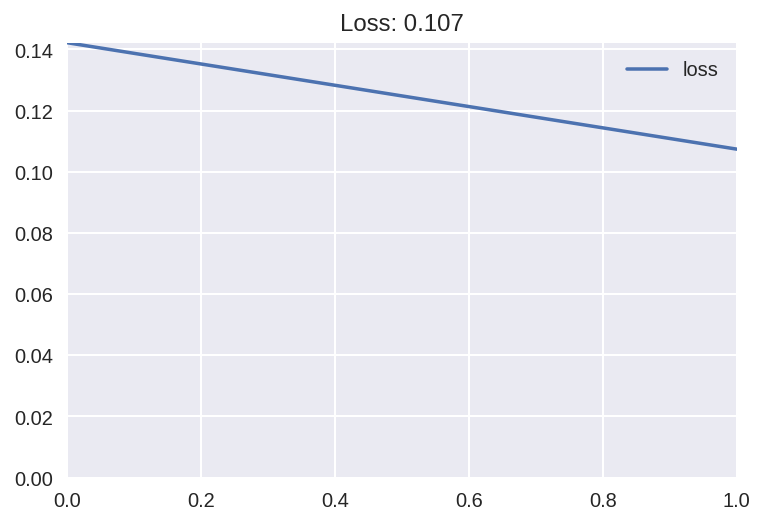

In [14]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))
plot_loss(encoder_history)